In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk

### Homework Part 1
Topic modelling using traditional NLP

In [52]:
dat = pd.read_csv("vaccination_all_tweets.csv")
dat.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [75]:
# need hashtags, id, text, user description [maybe weight by retweets (and user followers)]
X = dat[["text", "hashtags"]].copy()
X.head()

,text,hashtags
0,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech']
1,While the world has been on the wrong side of ...,NaN
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf..."
3,"Facts are immutable, Senator, even when you're...",NaN
4,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']"


In [54]:
# Preprocess text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

True

In [76]:
# Clean text
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    try:
        text = str(text)
        # Remove URLs
        text = re.sub(r'https:\S+|www\.\S+', '', text)
        # Remove user mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        # Remove special characters except basic punctuation
        text = re.sub(r'[^\w\s]', ' ', text)
        # Convert to lowercase
        text = text.lower()
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text
    except Exception as e:
        print(f"Error cleaning text: {e}")
        return ""

In [70]:
# Stemming text (except for user_name)
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    try:
        text = clean_text(text)
        # Tokenize and stem
        tokens = [stemmer.stem(word) for word in text.split() if word not in stop_words and len(word) > 2]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error preprocessing text: {e}")
        return ""

In [77]:
for col in X.columns:
    X[f"clean_{col}"] = X[col].apply(preprocess_text)
    

X.head()

,text,hashtags,clean_text,clean_hashtags
0,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],folk said daikon past could treat cytokin storm,pfizerbiontech
1,While the world has been on the wrong side of ...,NaN,world wrong side histori year hope biggest vac...,
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",russian vaccin creat last year,coronaviru sputnikv astrazeneca pfizerbiontech...
3,"Facts are immutable, Senator, even when you're...",NaN,fact immut senat even ethic sturdi enough ackn...,
4,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",explain need vaccin,whereareallthesickpeopl pfizerbiontech


In [87]:
# Word Embedding
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=5000,
                             min_df=1,
                             max_df=0.96,
                             stop_words= 'english')

text = X["clean_text"] + " " + X["clean_hashtags"]
text = text.tolist()

text_vec = vectorizer.fit_transform(text)

In [88]:
# Preliminary visualisations   
feature_names = np.array(vectorizer.get_feature_names_out())
count_vec = np.asarray(text_vec.sum(axis=0)).flatten() #puts data into 1d array
zipped = list(zip(feature_names, count_vec)) #reformats data into key value pairs


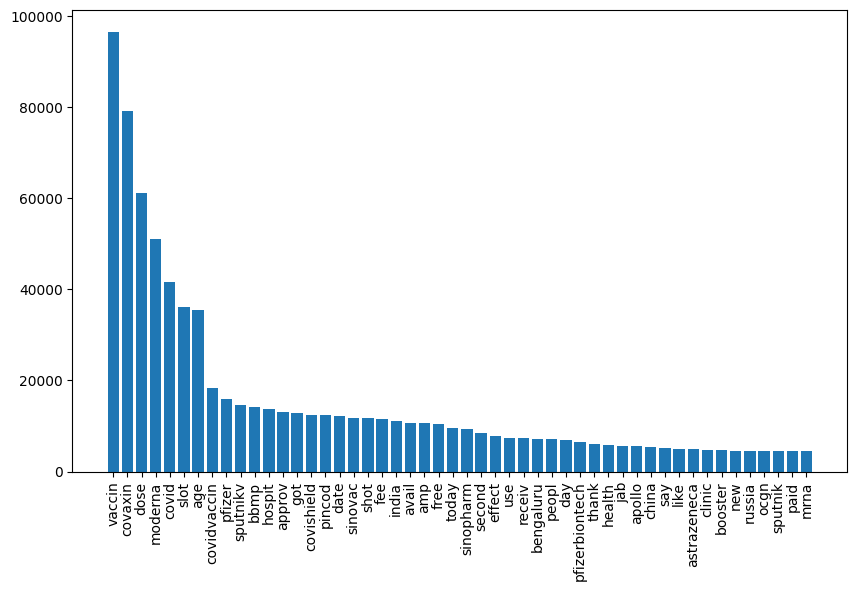

In [89]:

# Extract data into X_plot and Y_plot then plot
X_plot, Y_plot = (list(x) for x in zip(*sorted(zipped, key = lambda x: x[1], reverse = True))) #sort zipped descending then create a list for each element
Y_ = np.concatenate([Y_plot[0:15], Y_plot[-16:-1]]) # y values become top 15 and bottom 15 extracted data
X_ = np.concatenate([X_plot[0:15], X_plot[-16:-1]])

plt.figure(figsize=(10, 6))
plt.xticks(rotation=90) 
data = [plt.bar(
    x = X_plot[:50],
    height = Y_plot[:50],
)]


In [90]:
# Use LDA for traditional NLP
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, learning_method = 'batch', random_state=42, n_jobs= -1)
lda.fit(text_vec)


,n_components,10
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [91]:
# Topics generated by LDA
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)
        
n_top_words = 40
print("\nTopics in LDA model: ")
print_top_words(lda, feature_names, n_top_words)


Topics in LDA model: 

Topic #0:vaccin covaxin peopl like arm moderna day amp know pleas need mani sore let want feel time travel approv effect make think hour good world look shot oxfordastrazeneca come realli work hope countri took live right bodi jab anyon help

Topic #1:moderna vaccin got dose today shot second covid thank covidvaccin pfizerbiontech fulli jab day receiv week feel yesterday oxfordastrazeneca final amp booster getvaccin effect canada home happi stay vax grate wait appoint forc great morn good walk book trudeau famili

Topic #2:age covaxin slot dose pincod date fee bbmp hospit apollo sep aug clinic oct free jul jayanagar hosp pmc road rainbow rxdx pvt punecovaxin sputnik uphc columbia nagar ho asia forti aster manip nyati marg mumbai cloudnin miracl sakra motherhood

Topic #3:dose slot covidvaccin avail covishield free bengaluru paid covaxin bbmp urban sec rural gurgaoncovaxin hospit sector road plot pvt eye cloudnin citi max healthcar centr opp wellspr healthspr vis

In [92]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]
first_topic.shape

(5000,)

In [93]:
first_topic_words = [feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

In [94]:
#!pip install wordcloud

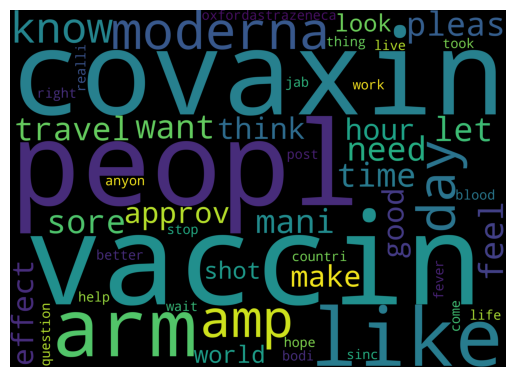

In [95]:
# Generating a wordcloud with the values under the category dataframe
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

firstcloud = WordCloud(
                          stopwords= stop_words,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

### Homework Part 2
Topic modelling using transformers

In [96]:
#!pip install transformers tf-keras
from transformers import pipeline, DistilBertTokenizer, DistilBertForSequenceClassification

In [97]:
import torch

classification = pipeline("zero-shot-classification", model="typeform/distilbert-base-uncased-mnli")
type(classification)

Device set to use cpu


transformers.pipelines.zero_shot_classification.ZeroShotClassificationPipeline

In [98]:
print(len(text))  # dataset size

228207


In [99]:
import random
sample = random.sample(text, 2000)


In [129]:
sample_labels = ["health", "politics", "economy", "mental health", "technology"]

# Get candidate labels using clustering
from sklearn.cluster import AgglomerativeClustering
agglo = AgglomerativeClustering()
labels = AgglomerativeClustering(n_clusters=5)

input_vec = vectorizer.fit_transform(sample).toarray()
labels = agglo.fit_predict(input_vec)
terms = vectorizer.get_feature_names_out()

unique_labels = np.unique(labels[labels >= 0])  # exclude noise (-1)
cluster_centroids = []

for label in unique_labels:
    cluster_indices = np.where(labels == label)[0]
    cluster_vecs = input_vec[cluster_indices]
    centroid = cluster_vecs.mean(axis=0)   # mean embedding
    cluster_centroids.append(centroid)

In [130]:
top_indices = np.array(centroid).ravel().argsort()[::-1][:n_top_words]
top_terms = [terms[i] for i in top_indices]
print(top_terms)

['vaccin', 'moderna', 'covid', 'dose', 'sputnikv', 'covaxin', 'pfizer', 'got', 'shot', 'amp', 'sinopharm', 'covidvaccin', 'today', 'sinovac', 'india', 'approv', 'use', 'china', 'receiv', 'second', 'pfizerbiontech', 'booster', 'day', 'peopl', 'like', 'effect', 'jab', 'russia', 'thank', 'report', 'health', 'fulli', 'mrna', 'coronaviru', 'emerg', 'case', 'year', 'countri', 'new', 'chines']


In [131]:
custom_labels = ["covaxin", "vaccine", "mental health", "dose", "shot"]
predictions = classification(sample, candidate_labels = custom_labels)
print(predictions)

[{'sequence': 'got vaccin canada certif vacc bless pfizer moderna covid amen', 'labels': ['vaccine', 'dose', 'mental health', 'shot', 'covaxin'], 'scores': [0.8871186971664429, 0.09176220744848251, 0.010224498808383942, 0.008155068382620811, 0.002739514922723174]}, {'sequence': 'get booster pfizer sinopharm abudhabi', 'labels': ['dose', 'vaccine', 'mental health', 'shot', 'covaxin'], 'scores': [0.9635289907455444, 0.014929044060409069, 0.012914017774164677, 0.006718758959323168, 0.0019091665744781494]}, {'sequence': 'avail free slot paid slot dose urban bengaluru covidvaccin covishield', 'labels': ['dose', 'shot', 'mental health', 'vaccine', 'covaxin'], 'scores': [0.9148495197296143, 0.04636317119002342, 0.016137344762682915, 0.013993498869240284, 0.008656430058181286]}, {'sequence': 'get symptom first shot experienc headach bodi ach testicl pain rash bloodi anu ', 'labels': ['shot', 'dose', 'mental health', 'vaccine', 'covaxin'], 'scores': [0.6814689040184021, 0.30973556637763977, 0.0

### Homework Part 3
Visualisations of topic modelling

In [132]:
results = []
for p in predictions:
    top_label = p['labels'][0]
    top_score = p['scores'][0]
    results.append((top_label, top_score))

eval_df = pd.DataFrame(results, columns=['topic', 'confidence'])


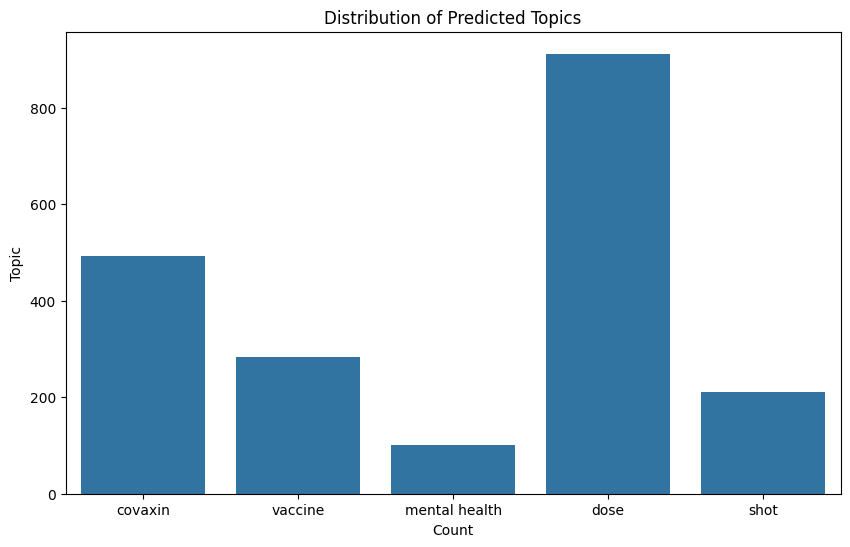

In [139]:
df = pd.DataFrame({"label": custom_labels})
plt.figure(figsize=(10,6))
sns.countplot(x="topic", data=eval_df, order=df["label"].value_counts().index)
plt.title("Distribution of Predicted Topics")
plt.xlabel("Count")
plt.ylabel("Topic")
plt.show()

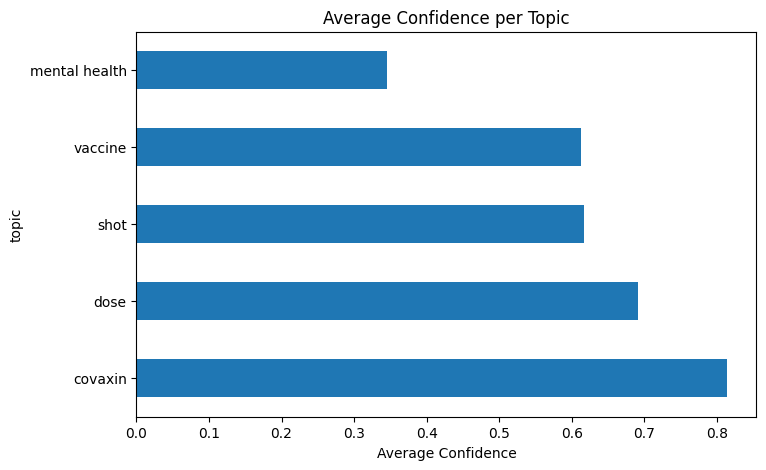

In [140]:
# Confidence per topic
avg_conf = eval_df.groupby('topic')['confidence'].mean().sort_values(ascending=False)
avg_conf.plot(kind='barh', figsize=(8,5), title="Average Confidence per Topic")
plt.xlabel("Average Confidence")
plt.show()
